# 背景

对指定个股和指数进行30分钟级别的监控，包括趋势、反转指标等，并通过语音进行报告。

本监控在数据上不依赖于zillionare-omega

In [1]:
! export HTTPS_PROXY=""
from alpha.notebook import *
from alpha.core.rsi_stats import rsiday, rsi30
import datetime
import itertools
import traceback
from IPython.display import display
from omicron.core.numpy_extensions import find_runs
await init_notebook()

g = {
    "notified": set(),
}


In [2]:
async def notify(frame, text, voice_only=False):
    key = f"{frame.hour:02d}:{frame.minute:02d} {text}"
    if key in g["notified"]:
        return
    
    if not voice_only:
        print(key)
    g["notified"].add(key)
    await nb_say(text)

In [3]:
async def do_check(holdings:List[str], candidates, check_at=None):
    end = arrow.now() if check_at is None else arrow.get(check_at)
    start = tf.shift(tf.floor(end, FrameType.MIN30), -39, FrameType.MIN30)
    
    for code in itertools.chain(["000001.XSHG"], holdings):
        sec = Security(code)
        try:
            bars = await sec.load_bars(start, end, FrameType.MIN30)
        except Exception as e:
            traceback.print_exception(e)
            continue
            
        bars = bars[np.isfinite(bars["close"])]
        close = bars["close"]
        
        rsi = relative_strength_index(close, period=6)[-1]
        prsi = rsi30.get_proba(code, rsi)
                        
        
            
        if prsi >= 0.9 and code in ["000001.XSHG", *holdings]:
            await notify(end, f"相对强弱指标显示，{sec.display_name}即将高位反转，概率为百分之{prsi:.0%}.")
        if prsi <= 0.1 and code in ["000001.XSHG"]:
            await notify(end, f"相对强弱指标显示，{sec.display_name}即将低位反转，概率为百分之{1-prsi:.0%}.")
    
async def mon(holdings, check_at=None):
    import asyncio
    
    holdings = [name_to_code(name) for name in holdings]
    
    now = arrow.now()
    wakeup_time = []
    for tm in ["10:00", "10:15", "10:30", "10:45", "11:00", "11:15", "11:30", "13:15", "13:30",
              "13:45", "14:00", "14:15", "14:30", "14:45"]:
        hour, minute = map(int, tm.split(":"))
        wakeup_time.append(arrow.Arrow(now.year, now.month, now.day, hour, minute, tzinfo="Asia/Shanghai"))
        
    if check_at:
        wakeup_time.insert(0, arrow.now().shift(seconds=5))
        
    end = tf.floor(arrow.now(), FrameType.DAY)
    start = tf.day_shift(end, -40)
    
    data = []
    for code in itertools.chain(["000001.XSHG"], holdings):
        sec = Security(code)
        bars = await sec.load_bars(start, end, FrameType.DAY)
        bars = bars[np.isfinite(bars["close"])]
        
        close = bars["close"]
        rsi = relative_strength_index(close, 6)[-3:]
        prsi = [round(rsiday.get_proba('000001.XSHG', r), 2) for r in rsi]

        data.append([sec.display_name, *prsi])
        
    df = pd.DataFrame(data, columns=["name", "rsi0", "rsi1", "rsi2"])
    display(df)
    
    for tm in wakeup_time:
        if arrow.now() > tm:
            continue
            
        seconds = (tm.timestamp - arrow.now().timestamp)
        await asyncio.sleep(seconds)
        print(f"=========== {tm.hour}:{tm.minute:02d}============")
        await do_check(holdings, check_at)

In [ ]:
holdings = [
    "中国西电", 
    "格林美", 
    "中国宝安",
    "惠泉啤酒",
    "方大集团",
    "天齐锂业",
    "长城科技",
    "湖北宜化",
]
await mon(holdings, arrow.now().shift(seconds=3))
print("一天监测结束")

In [ ]:
目标：
1. 检测当前均线是否已经拐头（越过-b/(2*a))
2. 如果均线呈直线，则4周期内涨跌幅是否超过阈值（大盘0.25)

,frame,prsi,rsi,ma_direct,to_vx,pmae,rlf,bear,bull
0,2021-10-20 11:30:00+08:00,0.75,67.16,-1,5.5,0.00027,0.33,None,True
1,2021-10-20 13:30:00+08:00,0.59,57.28,-1,-2.5,0.00021,0.67,True,None
2,2021-10-20 14:00:00+08:00,0.45,50.00,1,3.0,0.00007,-0.50,None,None
3,2021-10-20 14:30:00+08:00,0.49,52.34,1,3.8,0.00008,-1.00,None,None
4,2021-10-20 15:00:00+08:00,0.48,51.55,1,5.1,0.00009,-1.50,None,None
5,2021-10-21 10:00:00+08:00,0.64,60.56,1,-1.0,0.00011,0.33,None,None
6,2021-10-21 10:30:00+08:00,0.73,66.06,1,1.0,0.00011,0.67,None,True
7,2021-10-21 11:00:00+08:00,0.90,77.58,1,7.3,0.00022,1.00,None,None
8,2021-10-21 11:30:00+08:00,0.91,78.75,1,5.4,0.00018,1.33,None,True
9,2021-10-21 13:30:00+08:00,0.57,56.06,1,6.0,0.00017,-0.25,None,None


2021-11-06 11:07:53,379 W 14313 matplotlib.font_manager:_findfont_cached:1350 | findfont: Font family ['Microsoft YaHei', 'Heiti TC', 'Songti SC'] not found. Falling back to DejaVu Sans.
2021-11-06 11:07:53,454 W 14313 matplotlib.font_manager:_findfont_cached:1350 | findfont: Font family ['Microsoft YaHei', 'Heiti TC', 'Songti SC'] not found. Falling back to DejaVu Sans.


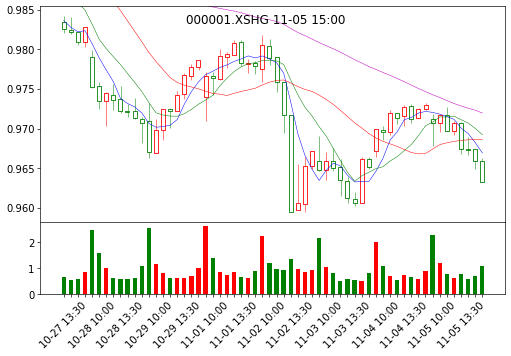

In [4]:
pd.options.display.max_rows = 200
end = arrow.get("2021-11-05 15:00")
start = tf.shift(end, -100, FrameType.MIN30)

cs = Candlestick({'30m': [5,10,20,60]})
await cs.plot("000001.XSHG", "2021-11-05 15:00")

results = []
for frame in tf.get_frames(start, end, FrameType.MIN30):
    frame = tf.int2time(frame)
    bars = await get_bars("000001.XSHG", 25, '30m', frame)
    features = flip_features("000001.XSHG", bars["close"], FrameType.MIN30)
    row = [frame, *features]
    results.append(row)
    
pd.DataFrame(results, columns=["frame", "prsi", "rsi", "ma_direct", "to_vx", "pmae", "rlf", "bear", "bull"])

In [6]:
# 大阴线或者连续阴线导致不规则的反转;反之亦然
bars = await get_bars("000001.XSHG", 25, '30m', "2021-10-20 13:30")
close = bars["close"]
if close[-1] < close[-6] and np.any(close[-5:-1]>close[-6]):
    long_bearish_line = True
else:
    long_bearish_line = None

if close[-1] > close[-6] and np.any(close[-5:-1]<close[-6]):
    long_bullish_line = True
else:
    long_bullish_line = None

In [7]:
long_bearish_line

True

In [11]:
close[-6:]

array([3593.15, 3579.55, 3584.07, 3585.68, 3594.38, 3589.86],
      dtype=float32)

In [10]:
bars["frame"]

array([datetime.datetime(2021, 10, 15, 13, 30, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')),
       datetime.datetime(2021, 10, 15, 14, 0, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')),
       datetime.datetime(2021, 10, 15, 14, 30, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')),
       datetime.datetime(2021, 10, 15, 15, 0, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')),
       datetime.datetime(2021, 10, 18, 10, 0, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')),
       datetime.datetime(2021, 10, 18, 10, 30, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')),
       datetime.datetime(2021, 10, 18, 11, 0, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')),
       datetime.datetime(2021, 10, 18, 11, 30, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')),
       datetime.datetime(2021, 10, 18, 13, 30, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')),
       datetime.datetime(2021, 10, 18, 14, 0, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')),
     